In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

2023-10-27 11:19:11.644969: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 11:19:12.279315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Data

The original dataset has taxa counts as rows and samples as columns. Since the goal here is to predict taxa counts in the same sample I transpose the original data such that one row represents taxa counts from the same sample. 

In [2]:
df = pd.read_csv(df_path, index_col="Unnamed: 0").T

In [3]:
print(df)

              1050608  130468   3589405  355102   1081058  189592   354275   \
E000823.1.8         0        0        0        0        0        0        0   
E000823.2.6         0        0        0        0        0        0        0   
E000823.4.0         0        0        0        0        0        0        0   
E000823.5.0         0        0        0        0        0        0        0   
E000823.5.7         0        0        0        0        0        0        0   
...               ...      ...      ...      ...      ...      ...      ...   
E014086.30.4        0        0        0        0        0        1       11   
E014086.32.4        0        0        0        0        0        0       13   
E014086.33.5        0        0        0        0        0        0        0   
E014086.34.4        0        0        0        0        0        1        0   
E014086.36.0        0        0        0        0        0        0        0   

              4327628  326749   183857   ...  31792

The dataset contains 521 samples of 7244 taxa, most of which are very sparsely populated 

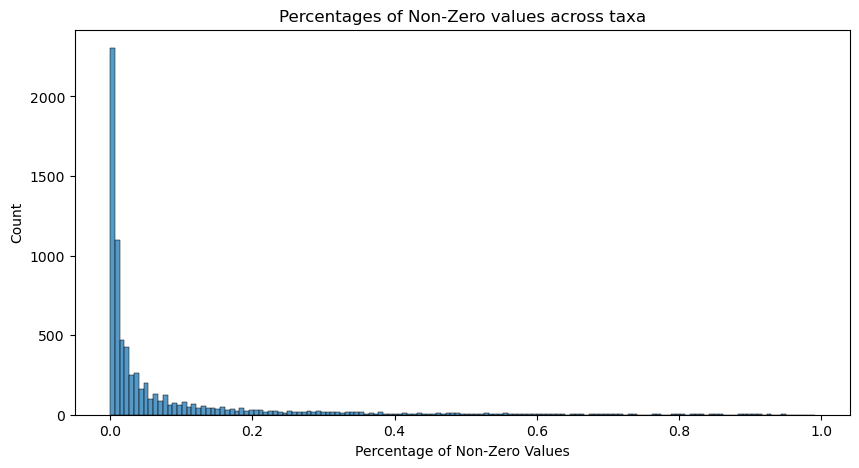

In [4]:
non_zero_value_counts = pd.Series([len(df[col][df[col] != 0]) for col in df.columns])
non_zero_value_pcts = non_zero_value_counts / len(df)

plt.figure(figsize=(10,5))
sns.histplot(non_zero_value_pcts)
plt.title("Percentages of Non-Zero values across taxa")
plt.xlabel("Percentage of Non-Zero Values")
plt.show()

In [5]:
non_zero_value_counts.describe()

count   7244.000000
mean      38.409856
std       71.884313
min        0.000000
25%        3.000000
50%        9.000000
75%       37.000000
max      516.000000
dtype: float64

### Preprocessing

In [6]:
df = load_and_merge()

In [7]:
def cut_to_sequences(feats_df, seq_length):
    # Description: cuts the dataframe into X_sequences of shape (seq_length, n_features) and y_targets

    # Example:
    # Our example data
    #    one  two  three
    # 0    1   11     21
    # 1    2   12     22
    # 2    3   13     23
    # 3    4   14     24
    # 4    5   15     25
    # 5    6   16     26
    # 6    7   17     27
    # 7    8   18     28
    # 8    9   19     29
    #
    # X_sequences, y_targets = cut_to_sequences(feats_df=example_df, seq_length=3)
    #
    # X_sequences[0] is [[ 1 11 21]
    #                    [ 2 12 22]
    #                    [ 3 13 23]]
    #
    # y_targets[0] is    [ 4 14 24]

    num_features = len(feats_df.columns)

    X_sequences = []
    y_targets = pd.Series(dtype=float)

    for i in range(len(feats_df) - seq_length):
        target_idx = feats_df.iloc[i + seq_length].name
        
        X_sequences.append(feats_df.iloc[i:i + seq_length])
        y_targets[target_idx] = feats_df.loc[target_idx]

    X_sequences = np.asarray(X_sequences)
    
    return X_sequences, y_targets


In [8]:
def feats_and_targets(df, seq_length):

    feats = []
    targets = []
    
    subjects = df.subject_id.unique()
    df_subject_grp = df.groupby("subject_id")
    
    for subject_id in subjects:
        subject_df = df_subject_grp.get_group(subject_id).drop(columns=["subject_id"])
        subject_feats, subject_targets = cut_to_sequences(subject_df, seq_length=seq_length)
    
        for sequence_idx in range(len(subject_feats)):
            feats.append(subject_feats[sequence_idx])
            targets.append(subject_targets[sequence_idx])
    
    targets = pd.concat(targets, axis=1).T
    feats = np.asarray(feats)
    
    return feats, targets

In [63]:
def feats_and_targets(df, seq_length, n_test_seq):
    
    subjects = df.subject_id.unique()
    df_subject_grp = df.groupby("subject_id")
    
    test_subjects_idx = np.random.choice(len(subjects), size=n_test_seq, replace=False)
    test_subjects = subjects[test_subjects_idx]
    
    print(f"The test subjects are {test_subjects}")
    
    train_feats = []
    train_targets = []
    test_feats = []
    test_targets = []
    test_subject_idx = []
    for subject_id in subjects:
        subject_df = df_subject_grp.get_group(subject_id).drop(columns=["subject_id"])
        subject_feats, subject_targets = cut_to_sequences(subject_df, seq_length=seq_length)
    
        for sequence_idx in range(len(subject_feats)):
            
            if subject_id in test_subjects:
                test_feats.append(subject_feats[sequence_idx])
                test_targets.append(subject_targets[sequence_idx])
                test_subject_idx.append(subject_id)
            else:
                train_feats.append(subject_feats[sequence_idx])
                train_targets.append(subject_targets[sequence_idx]) 
                
    # shuffle the train features and targets
    random_order = np.random.permutation(len(train_feats))
    
    train_feats = np.asarray(train_feats)[random_order]
    train_targets = np.asarray(train_targets)[random_order]
    
    # do not shuffle the test set
    test_feats = np.asarray(test_feats)
    
    # restore the subject_id for the test_targets so that it could be later used in evaluations
    test_targets = pd.concat(test_targets, axis=1).T
    test_targets["subject_id"] = test_subject_idx

    return train_feats, train_targets, test_feats, test_targets

In [64]:
max_zeros_pct = 0.5
window_size = 3
sequence_length = 10

df = load_and_merge()

df = remove_underpopulated_taxa(df, max_zeros_pct)
df = standard_rolling_average(df, window_size)
df = feature_wise_scaling(df)

In [65]:
df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,3304236,584137,193233,4334711,196664,583117,354850,subject_id,sampling_day,ind_time
E000823.4.0,0.000000,0.000160,0.288889,0.000000,0.000000,0.242718,0.010256,0.190476,0.000000,0.100671,...,0.029412,0.000000,0.040201,0.455696,0.059699,0.010154,0.064039,E000823,0.072046,0.072046
E000823.5.0,0.000000,0.000160,0.200000,0.000000,0.000000,0.199029,0.007692,0.119048,0.000000,0.120805,...,0.117647,0.000000,0.035804,0.398734,0.054162,0.010779,0.029557,E000823,0.100865,0.100865
E000823.5.7,0.000000,0.000180,0.200000,0.003724,0.000000,0.228155,0.007692,0.023810,0.000000,0.053691,...,0.117647,0.000000,0.034338,0.518987,0.060045,0.009685,0.019704,E000823,0.121037,0.121037
E000823.6.7,0.065636,0.000160,0.088889,0.016139,0.000000,0.121359,0.002564,0.023810,0.000000,0.080537,...,0.205882,0.000085,0.021566,0.386076,0.035127,0.006092,0.000000,E000823,0.149856,0.149856
E000823.8.5,0.065636,0.000220,0.177778,0.017381,0.000000,0.490291,0.020513,0.071429,0.000000,0.053691,...,0.176471,0.000085,0.050251,0.386076,0.061602,0.037334,0.000000,E000823,0.201729,0.201729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,0.060355,0.080890,0.288889,0.007449,0.044379,0.111650,0.025641,0.476190,0.479017,0.503356,...,0.470588,0.055292,0.091290,0.253165,0.127531,0.423113,0.068966,E014086,0.832853,0.832853
E014086.32.4,0.060355,0.120524,0.622222,0.010552,0.077663,0.194175,0.071795,0.404762,0.880928,0.711409,...,0.441176,0.071990,0.142169,0.341772,0.345042,0.622876,0.285714,E014086,0.890490,0.890490
E014086.33.5,0.051679,0.141802,1.000000,0.011173,0.161243,0.436893,0.074359,0.619048,0.849198,0.906040,...,0.264706,0.057024,0.213358,0.373418,0.537809,0.756436,0.507389,E014086,0.922190,0.922190
E014086.34.4,0.021124,0.127490,0.977778,0.004345,0.160503,0.572816,0.071795,0.571429,0.761174,0.899329,...,0.294118,0.037543,0.241625,0.316456,0.631597,0.749125,0.610837,E014086,0.948127,0.948127


### Features and tergets


In [97]:
number_test_sequences = 3

train_feats, train_targets, test_feats, test_targets = feats_and_targets(df, seq_length=sequence_length, n_test_seq=number_test_sequences)

The test subjects are ['E000823' 'E004898' 'E011878']


In [98]:
print(len(train_feats), len(train_targets))
print(len(test_feats), len(test_targets))

276 276
43 43


### The Model

In [99]:
reg = 1e-12
loss=mae_ignore_zeros(false_positives_penalty_factor=0.3)

n_feats = len(df.columns) - 1

model = Sequential()
model.add(keras.Input(shape=(sequence_length, n_feats)))
model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
model.add(keras.layers.Dense(2048, activation="tanh", kernel_regularizer=l1_l2(reg)))
model.add(keras.layers.Dense(n_feats, activation="relu", kernel_regularizer=l1_l2(reg)))

model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1024)              5033984   
                                                                 
 dense_10 (Dense)            (None, 2048)              2099200   
                                                                 
 dense_11 (Dense)            (None, 204)               417996    
                                                                 
Total params: 7551180 (28.81 MB)
Trainable params: 7551180 (28.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training and Validation

In [101]:
train_feats = np.asarray(train_feats)
train_targets = np.asarray(train_targets)

model.fit(x=train_feats, y=train_targets, validation_split=0.05, epochs=100)

Epoch 1/100
9/9 [==============================] - 0s 17ms/step - loss: 4.7871 - mae: 0.0370 - mape: 100094.0859 - val_loss: 6.2501 - val_mae: 0.0516 - val_mape: 242985.0000
Epoch 2/100
9/9 [==============================] - 0s 14ms/step - loss: 4.6890 - mae: 0.0361 - mape: 128687.7734 - val_loss: 6.3090 - val_mae: 0.0520 - val_mape: 261683.3281
Epoch 3/100
9/9 [==============================] - 0s 15ms/step - loss: 4.7279 - mae: 0.0365 - mape: 78633.1875 - val_loss: 6.1292 - val_mae: 0.0507 - val_mape: 195969.6406
Epoch 4/100
9/9 [==============================] - 0s 15ms/step - loss: 4.8006 - mae: 0.0372 - mape: 105927.7891 - val_loss: 6.1617 - val_mae: 0.0507 - val_mape: 252743.8281
Epoch 5/100
9/9 [==============================] - 0s 14ms/step - loss: 4.7891 - mae: 0.0370 - mape: 119939.1406 - val_loss: 6.3207 - val_mae: 0.0527 - val_mape: 172100.6406
Epoch 6/100
9/9 [==============================] - 0s 14ms/step - loss: 4.7325 - mae: 0.0366 - mape: 119870.0859 - val_loss: 6.2505

In [102]:
y_test_df = test_targets.copy()
y_test_df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,3304236,584137,193233,4334711,196664,583117,354850,sampling_day,ind_time,subject_id
E000823.17.6,0.000000,0.000060,0.155556,0.000621,0.025888,0.014563,0.000000,0.071429,0.144661,0.134228,...,0.088235,0.019055,0.003559,0.037975,0.012459,0.144776,0.137931,0.463977,0.463977,E000823
E000823.18.7,0.000000,0.000180,0.177778,0.000621,0.042160,0.048544,0.007692,0.285714,0.292050,0.194631,...,0.147059,0.062733,0.011097,0.107595,0.024745,0.264090,0.167488,0.495677,0.495677,E000823
E000823.20.0,0.000000,0.000280,0.311111,0.000621,0.105769,0.116505,0.007692,0.476190,0.293415,0.241611,...,0.176471,0.117144,0.015285,0.246835,0.043087,0.307361,0.054187,0.533141,0.533141,E000823
E000823.22.6,0.000000,0.000280,0.333333,0.000621,0.118343,0.126214,0.007692,0.500000,0.201296,0.214765,...,0.117647,0.158407,0.016960,0.240506,0.045510,0.301300,0.049261,0.608069,0.608069,E000823
E000823.24.3,0.030177,0.000180,0.266667,0.000621,0.090237,0.121359,0.000000,0.261905,0.030706,0.134228,...,0.029412,0.113197,0.013610,0.183544,0.040664,0.203637,0.024631,0.657061,0.657061,E000823
E000823.25.0,0.030555,0.000080,0.088889,0.000000,0.022189,0.058252,0.002564,0.047619,0.041624,0.080537,...,0.029412,0.064152,0.021566,0.044304,0.025437,0.151368,0.059113,0.677233,0.677233,E000823
E000823.25.7,0.049793,0.000100,0.111111,0.000000,0.011095,0.121359,0.020513,0.023810,0.032071,0.154362,...,0.117647,0.024678,0.049623,0.044304,0.054508,0.140465,0.059113,0.697406,0.697406,E000823
E000823.27.7,0.029046,0.000240,0.155556,0.001862,0.021450,0.111650,0.069231,0.095238,0.030365,0.174497,...,0.117647,0.042342,0.139866,0.044304,0.142585,0.179361,0.059113,0.755043,0.755043,E000823
E000823.29.6,0.028668,0.000540,0.311111,0.001862,0.104290,0.131068,0.100000,0.095238,0.028659,0.241611,...,0.117647,0.046432,0.169179,0.044304,0.194151,0.223288,0.029557,0.809798,0.809798,E000823
E000823.29.7,0.009430,0.000460,0.244444,0.004345,0.098373,0.053398,0.082051,0.285714,0.021153,0.255034,...,0.411765,0.041008,0.137353,0.025316,0.155390,0.166552,0.059113,0.812680,0.812680,E000823


In [103]:
y_pred = model.predict(test_feats)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df["subject_id"] = y_test_df.subject_id.tolist()
y_pred_df.columns = y_test_df.columns
y_pred_df.index = y_test_df.index

y_pred_df

2/2 [==============================] - 0s 3ms/step


,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,3304236,584137,193233,4334711,196664,583117,354850,sampling_day,ind_time,subject_id
E000823.17.6,0.015932,0.000000,0.160166,0.000000,0.047486,0.087223,0.063860,0.244041,0.122728,0.219577,...,0.181226,0.000000,0.110750,0.108486,0.105957,0.134228,0.212533,0.481415,0.477524,E000823
E000823.18.7,0.019758,0.005920,0.133698,0.000000,0.033950,0.081656,0.062970,0.225478,0.141155,0.191299,...,0.156410,0.000000,0.109038,0.093646,0.107735,0.127952,0.205850,0.511586,0.506461,E000823
E000823.20.0,0.022532,0.008492,0.149814,0.000000,0.031087,0.101991,0.076758,0.256274,0.189125,0.201065,...,0.176430,0.000000,0.136559,0.111842,0.124496,0.151103,0.215685,0.571499,0.564510,E000823
E000823.22.6,0.049489,0.009101,0.269995,0.000000,0.051516,0.275342,0.122161,0.435289,0.308680,0.334458,...,0.336476,0.000000,0.232947,0.231450,0.197941,0.225023,0.326281,0.715629,0.702120,E000823
E000823.24.3,0.028619,0.004813,0.308964,0.000000,0.058570,0.332471,0.105326,0.410420,0.271935,0.382076,...,0.328317,0.000000,0.222618,0.231399,0.228306,0.248405,0.381196,0.728631,0.718292,E000823
E000823.25.0,0.014443,0.000000,0.248649,0.000000,0.050410,0.265191,0.066930,0.324704,0.159614,0.349227,...,0.240236,0.000000,0.150975,0.152979,0.184580,0.187816,0.352080,0.698914,0.693749,E000823
E000823.25.7,0.006992,0.000000,0.139188,0.000000,0.024829,0.142988,0.037092,0.196337,0.075841,0.232005,...,0.118697,0.000000,0.084236,0.072225,0.110968,0.106764,0.267597,0.658409,0.656262,E000823
E000823.27.7,0.003566,0.000000,0.112821,0.000000,0.011854,0.101592,0.044314,0.156221,0.081408,0.180935,...,0.095518,0.000000,0.084393,0.053181,0.101190,0.102675,0.242355,0.649001,0.646347,E000823
E000823.29.6,0.007613,0.000000,0.135483,0.000000,0.000671,0.141004,0.084090,0.175714,0.122273,0.193464,...,0.137138,0.000000,0.139127,0.064996,0.147317,0.138636,0.218901,0.687100,0.683515,E000823
E000823.29.7,0.006836,0.000000,0.194010,0.000000,0.005041,0.230029,0.134887,0.234432,0.167628,0.246420,...,0.210032,0.000000,0.206657,0.101962,0.217874,0.201026,0.213879,0.734800,0.728541,E000823


Usually at least some of the taxa are not predictable by a model. Then it returns zeros for their entire sequence

In [104]:
non_predicted_cols = [col for col in y_pred_df.columns if all(y_pred_df[col] == 0.0)]
n_non_predicted_cols = len(non_predicted_cols)

print(f"Total taxa not predicted: {n_non_predicted_cols}, {(n_non_predicted_cols/len(y_test_df.columns)) * 100}% of all taxa")

Total taxa not predicted: 31, 15.121951219512194% of all taxa


The next section allows to examine individual true and predicted sequences

In [105]:
test_subjects = y_test_df.subject_id.unique()
test_subjects

array(['E000823', 'E004898', 'E011878'], dtype=object)

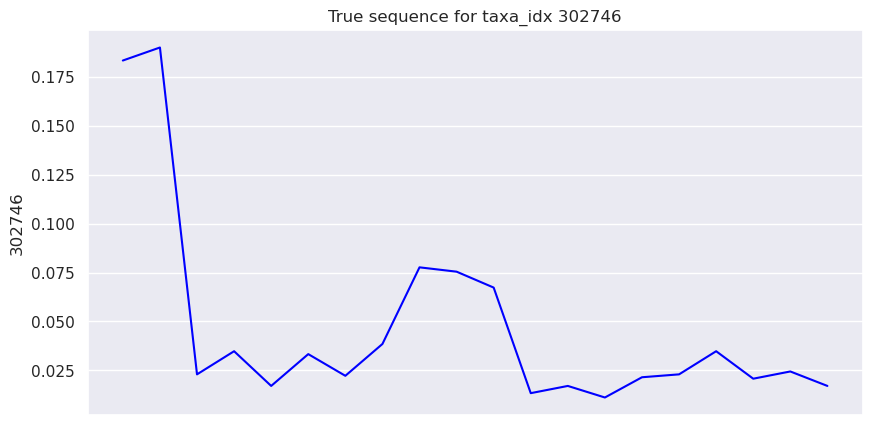

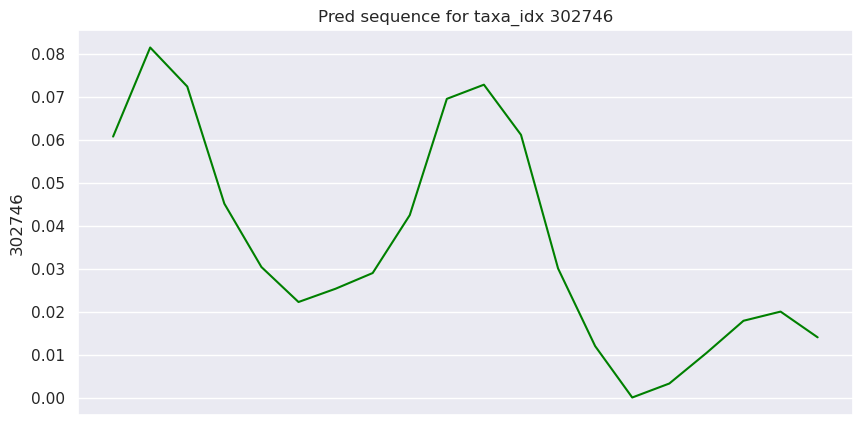

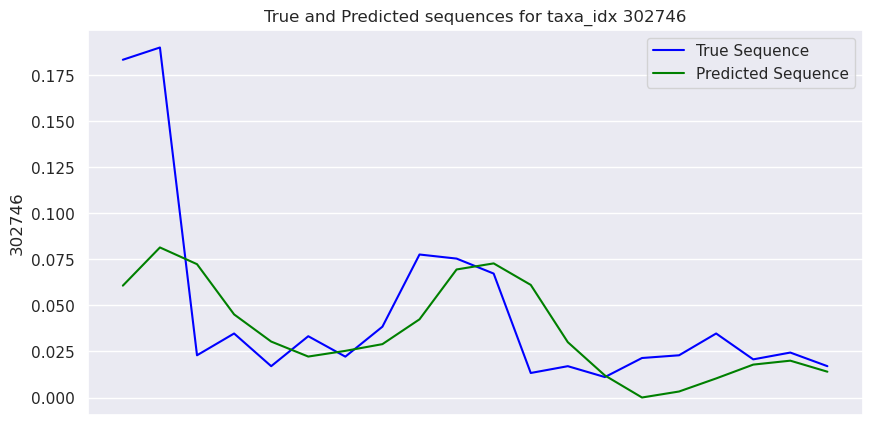

In [109]:
target_taxa = 302746
target_subject_idx = 2

target_subject = test_subjects[target_subject_idx]

true_sequence = y_test_df[y_test_df.subject_id == target_subject][target_taxa].reset_index(drop=True)
pred_sequence = y_pred_df[y_pred_df.subject_id == target_subject][target_taxa].reset_index(drop=True)

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

Now I look at the performance across different sequences

In [91]:
errors_df = calculate_percentage_errors(y_pred_df, y_test_df)
errors_df.describe()


,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,...,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,320452285.130099,0.789472,0.514226,0.947368,283682028.583032,0.595940,203159137.263762,0.880672,0.769393,0.371591,...,0.779730,0.615948,0.736840,222011727.166153,3.202815,5.314127,16169283.671638,0.871315,0.612203,1.862477
std,530439772.413865,0.418853,0.187432,0.229416,342761123.196376,0.628836,362396777.735726,0.987874,0.481477,0.359067,...,0.674564,0.433606,0.452413,673061010.262117,9.601851,4.407697,70480272.001978,0.918977,0.223760,2.409950
min,0.767161,0.000000,0.200265,0.000000,0.240720,0.042871,0.000000,0.030021,0.053454,0.047038,...,0.110094,0.035477,0.000000,0.050589,0.999996,0.481085,0.035748,0.142311,0.173358,0.010105
25%,22.704979,0.999995,0.403419,1.000000,1.960121,0.194781,0.854055,0.279223,0.509397,0.254520,...,0.303510,0.269375,0.499998,0.314157,0.999999,1.844233,0.224560,0.343718,0.503427,0.138828
50%,227.931155,0.999998,0.501448,1.000000,48.090173,0.359874,17.608320,0.465948,0.645034,0.333853,...,0.676215,0.520940,0.999996,0.817397,0.999999,4.182827,0.330131,0.563893,0.599826,0.381605
75%,758970007.300377,0.999999,0.628892,1.000000,580163449.048996,0.740361,223492234.129494,0.926955,1.000000,0.374772,...,1.044486,0.870255,0.999998,1.001302,1.000000,7.725351,0.538751,0.680704,0.830682,2.827866
max,1828564703.464508,1.000000,0.859689,1.000000,870050713.419914,2.418474,940914005.041122,3.429993,2.319521,1.739740,...,2.654191,1.632508,1.000000,2420554310.083389,42.853499,16.150157,307216383.516788,3.207175,0.919114,8.746440


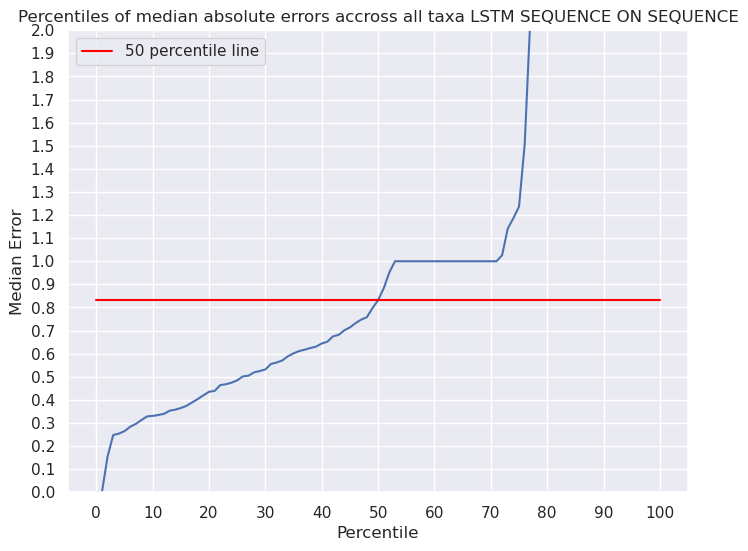

In [92]:
percentile_graph(errors_df, "accross all taxa LSTM SEQUENCE ON SEQUENCE", y_top_lim=2)

Same graph, but only for those taxa that are not all predicted zero

In [93]:
only_predicted_errors = errors_df[errors_df.columns[~(errors_df.columns.isin(non_predicted_cols))]]
only_predicted_errors.describe()

,659361,3439402,302746,4473763,175535,3887769,585227,189384,3465320,865469,...,577170,359650,130663,3304236,584137,193233,4334711,196664,583117,354850
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,...,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,320452285.130099,0.514226,283682028.583032,0.595940,203159137.263762,0.880672,0.769393,0.371591,4.129458,7.142070,...,0.662462,0.779730,0.615948,222011727.166153,3.202815,5.314127,16169283.671638,0.871315,0.612203,1.862477
std,530439772.413865,0.187432,342761123.196376,0.628836,362396777.735726,0.987874,0.481477,0.359067,3.910433,8.578094,...,0.149206,0.674564,0.433606,673061010.262117,9.601851,4.407697,70480272.001978,0.918977,0.223760,2.409950
min,0.767161,0.200265,0.240720,0.042871,0.000000,0.030021,0.053454,0.047038,0.000000,0.126105,...,0.284382,0.110094,0.035477,0.050589,0.999996,0.481085,0.035748,0.142311,0.173358,0.010105
25%,22.704979,0.403419,1.960121,0.194781,0.854055,0.279223,0.509397,0.254520,0.481432,0.570285,...,0.601630,0.303510,0.269375,0.314157,0.999999,1.844233,0.224560,0.343718,0.503427,0.138828
50%,227.931155,0.501448,48.090173,0.359874,17.608320,0.465948,0.645034,0.333853,2.895577,3.013426,...,0.708505,0.676215,0.520940,0.817397,0.999999,4.182827,0.330131,0.563893,0.599826,0.381605
75%,758970007.300377,0.628892,580163449.048996,0.740361,223492234.129494,0.926955,1.000000,0.374772,7.057161,12.113740,...,0.751618,1.044486,0.870255,1.001302,1.000000,7.725351,0.538751,0.680704,0.830682,2.827866
max,1828564703.464508,0.859689,870050713.419914,2.418474,940914005.041122,3.429993,2.319521,1.739740,11.324349,27.462738,...,0.858139,2.654191,1.632508,2420554310.083389,42.853499,16.150157,307216383.516788,3.207175,0.919114,8.746440


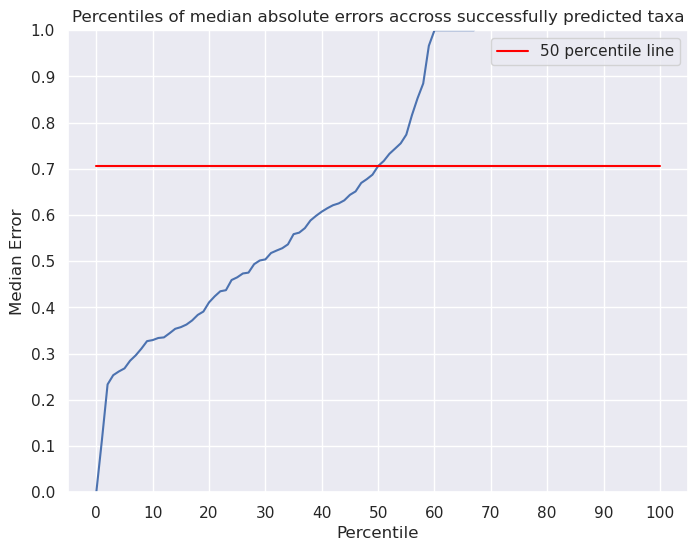

In [94]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa", y_top_lim=1)